In [1]:
"""
Utility functions for plotting Bloch spheres on matplotlib ax.
Extracted and refactored from QuTiP's Bloch sphere implementation.
"""

import numpy as np
from numpy import linspace, cos, sin, ones, outer, pi, size
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

import torch
import qutip

import sys
# ! TODO : modify path for your environment
# sys.path.append("/Users/hun/circuit")
sys.path.append("/home/hun/circuit")


sphere_color="#FFDDDD"
sphere_alpha = 0.2
frame_color = 'gray'
frame_alpha = 0.2
frame_width = 1

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

def show_label(ax, **opts):
    ax.scatter(-1,0,0, "$-1$", color="black")
    ax.scatter(1,0,0, "$1$", color="black")
    ax.scatter(0,-1,0, "$-1$", color="black")
    ax.scatter(0,1,0, "$1$", color="black")
    ax.scatter(0,0,-1, "$-1$", color="black")
    ax.scatter(0,0,1, "$1$", color="black")

    ax.text(-1.2, 0, 0, "$-x$", **opts)
    ax.text( 1.2, 0, 0,  "$x$", **opts)

    ax.text(0, -1.2, 0, "$-y$", **opts)
    ax.text(0,  1.2, 0,  "$y$", **opts)

    ax.text(0, 0, -1.2, "$-z$", **opts)
    ax.text(0, 0,  1.2,  "$z$", **opts)

def plot_back(ax):
    # back half of sphere
    u = linspace(0, pi, 25)
    v = linspace(0, pi, 25)
    x = outer(cos(u), sin(v))
    y = outer(sin(u), sin(v))
    z = outer(ones(size(u)), cos(v))
    ax.plot_surface(x, y, z, rstride=2, cstride=2,
                            color=sphere_color, linewidth=0,
                            alpha=sphere_alpha)
    # wireframe
    ax.plot_wireframe(x, y, z, rstride=5, cstride=5,
                                color=frame_color,
                                alpha=frame_alpha)
    # equator
    ax.plot(1.0 * cos(u), 1.0 * sin(u), zs=0, zdir='z',
                    lw=frame_width, color=frame_color)
    ax.plot(1.0 * cos(u), 1.0 * sin(u), zs=0, zdir='x',
                    lw=frame_width, color=frame_color)

def plot_front(ax):
    # front half of sphere
    u = linspace(-pi, 0, 25)
    v = linspace(0, pi, 25)
    x = outer(cos(u), sin(v))
    y = outer(sin(u), sin(v))
    z = outer(ones(size(u)), cos(v))
    ax.plot_surface(x, y, z, rstride=2, cstride=2,
                            color=sphere_color, linewidth=0,
                            alpha=sphere_alpha)
    # wireframe
    ax.plot_wireframe(x, y, z, rstride=5, cstride=5,
                                color=frame_color,
                                alpha=frame_alpha)
    # equator
    ax.plot(1.0 * cos(u), 1.0 * sin(u),
                    zs=0, zdir='z', lw=frame_width,
                    color=frame_color)
    ax.plot(1.0 * cos(u), 1.0 * sin(u),
                    zs=0, zdir='x', lw=frame_width,
                    color=frame_color)

In [2]:
from scipy.linalg import expm
X = np.array([
    [0,1],
    [1,0]
], dtype=np.complex128)

Y = np.array([
    [0, -1j],
    [1j, 0]
], dtype=np.complex128)
Z = np.array([
    [1, 0],
    [0, -1]
], dtype=np.complex128)

initial_state = np.zeros(2, dtype=np.complex128)
initial_state[0] = 1

dt = 1e-2
tlist = np.arange(0, np.pi, dt)
exp_x = np.zeros_like(tlist)
exp_y = np.zeros_like(tlist)
exp_z = np.zeros_like(tlist)

exp_x[0] = np.einsum("i,ij,j", initial_state.conj(), X, initial_state)
exp_y[0] = np.einsum("i,ij,j", initial_state.conj(), Y, initial_state)
exp_z[0] = np.einsum("i,ij,j", initial_state.conj(), Z, initial_state)

expval = {
    "X" : exp_x,
    "Y" : exp_y,
    "Z" : exp_z,
}

for i, t in enumerate(tlist[1:]):
    initial_state = expm(-1j*dt*X) @ initial_state
    exp_x[i+1] = np.einsum("i,ij,j", initial_state.conj(), X, initial_state).real
    exp_y[i+1] = np.einsum("i,ij,j", initial_state.conj(), Y, initial_state).real
    exp_z[i+1] = np.einsum("i,ij,j", initial_state.conj(), Z, initial_state).real

/tmp/ipykernel_118879/3229403588.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  exp_x[0] = np.einsum("i,ij,j", initial_state.conj(), X, initial_state)
/tmp/ipykernel_118879/3229403588.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  exp_y[0] = np.einsum("i,ij,j", initial_state.conj(), Y, initial_state)
/tmp/ipykernel_118879/3229403588.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  exp_z[0] = np.einsum("i,ij,j", initial_state.conj(), Z, initial_state)


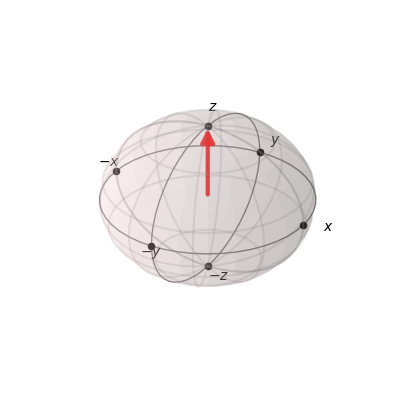

In [3]:
from matplotlib.animation import FuncAnimation

# Create your animation
fig = plt.figure(figsize=(5, 5), facecolor="#ffffff")
ax = fig.add_subplot(1, 1, 1, projection='3d')

def animate(frame):
    ax.clear()
    plot_back(ax)
    plot_front(ax)
    show_label(ax)
    
    # Plot trajectory up to current frame
    ax.plot(expval["X"][:frame], expval["Y"][:frame], 
            expval["Z"][:frame], 'b-', alpha=0.3, linewidth=1)
    
    # Current state arrow
    a = Arrow3D(xs=[0, expval["X"][frame]], 
                ys=[0, expval["Y"][frame]], 
                zs=[0, expval["Z"][frame]], 
                mutation_scale=20, lw=3, arrowstyle="-|>", 
                color="red", alpha=0.9)
    ax.add_artist(a)
    
    ax.axis("off")
    ax.view_init(azim=-60, elev=30)

# Create animation
anim = FuncAnimation(fig, animate, frames=len(tlist), 
                     interval=50, blit=False)


In [4]:
anim.save('rx_gate_rotation.gif', writer='pillow', fps=600)